In [16]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

In [17]:
sites = ['Dartmouth', 'Jefferson','Emory', 'UTSW']
sel_sub = pd.DataFrame([])
subs = []
for site in sites:
    #df = pd.read_excel(r'./' + site + '_neuropsych.xlsx',engine="openpyxl")
    df = pd.read_excel(r'./' + site + '_neuropsych.xlsx')
    for i in df.index:
        #gap = df.iloc[i]['Time between report and implant (days)']
        BDI = df.iloc[i]['BDI']
        BAI = df.iloc[i]['BAI']
        sub = df.iloc[i]['Subject Number']
        #if gap < 183 and np.isnan(BDI)==False and np.isnan(BAI)==False:
        if np.isnan(BDI)==False and np.isnan(BAI)==False:
            sel_sub = sel_sub.append({
                'subject':sub,
                'BDI':BDI,
                'BAI':BAI
                }, ignore_index = True)
sel_sub

,BAI,BDI,subject
0,3.0,6.0,32.0
1,4.0,3.0,33.0
2,27.0,14.0,98.0
3,11.0,39.0,100.0
4,9.0,8.0,116.0
...,...,...,...
161,6.0,0.0,457.0
162,18.0,13.0,474.0
163,5.0,3.0,478.0
164,4.0,3.0,531.0


In [18]:
df = get_data_index('r1')
df_subs = df['subject'].unique()
df_select = pd.DataFrame([])
df_subs
tmp = []
select = []
for sub in df_subs:
    num = int(sub[2:5])
    for i in sel_sub.index:
        sel = sel_sub.iloc[i]['subject']
        if sel == num:
            df_select = df_select.append({
                'subject':sub,
                'BDI':sel_sub.iloc[i]['BDI'],
                'BAI':sel_sub.iloc[i]['BAI']
                }, ignore_index = True)

In [19]:
trial_df = pd.DataFrame([])
experiments = ['FR1','catFR1']

for sub in df_select['subject']: ### 'sub' instead of 's' 
    try:
        for exp in experiments:
            localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        

            for loc in localizations:
                montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            

                for mont in montages: # iterate over montages            
                    data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                    sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()

                    for sess in sessions: # 'sess' instead of 'k' 
                        reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                        evs = reader.load('task_events')
                        word_evs = evs[evs['type']=='REC_WORD']
    #                     rec_evs = word_evs[word_evs['recalled']==True]
                        s_dict = {} #create variables for each field and then append using Noa's technique

                        ### many times there are negative lists, referring to practice lists. You want to
                        # exclude those: word_evs['list'][word_evs['list']>0].unique() 
                        lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                        corr_recs = len(word_evs[word_evs['intrusion']==0]) # changed
                        ELIs = len(word_evs[word_evs['intrusion']==-1])
                        PLIs = len(word_evs[word_evs['intrusion']>0])
                        total_ints = ELIs + PLIs
                        total_trials = corr_recs + total_ints

                        trials = []
                        for list_num in word_evs['list'][word_evs['list']>0].unique():
                            list_events=word_evs[word_evs['list']==list_num]
                            if len(list_events)>0: 
                                for i in range(0,len(list_events)):
                                    trials.append(list_events.index[i])               

                        trial_df = trial_df.append({
                            'subject':sub,
                            'session': sess,
                            'montage': mont,
                            'localization': loc,
                            'experiment': exp,
                            'number of lists': lists,
                            'number of correct recalls': corr_recs,
                            'number of extra-list intrusions': ELIs,
                            'number of prior-list intrusions': PLIs,
                            'total number of intrusions': total_ints,
                            'total number of trials left': total_trials,
                            'trials for analysis': trials
                            },ignore_index=True )  
    except:
        print('Failed for subject:' + sub)

In [20]:
df_filter = pd.DataFrame([])

for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        lists = trial_df.iloc[i]['number of lists']
        exp = trial_df.iloc[i]['experiment']
        #max number of lists is either 12 or 25 for catFR1 depending on version. Always 25 for FR1
        sc_correc = float(correc/lists)*25
        sceli = float(eli/lists)*25
        scpli = float(pli/lists)*25
        df_filter = df_filter.append({
            'subject':sub,
            'experiment':exp,
            'correct recalls':correc,
            'ELIs':eli,
            'PLIs':pli,
            'total ints': eli+pli,
            'lists':lists,
            'correct recalls scaled':sc_correc,
            'ELI scaled':sceli,
            'PLI scaled':scpli,
            'total scaled':sceli+scpli,
            'BAI':int(row['BAI'].values),
            'BDI':int(row['BDI'].values)
        }, ignore_index = True)
    except:
        continue
df_filter

/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home1/evsnyder/.conda/envs/cmlreader0/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,correct recalls,correct recalls scaled,experiment,lists,subject,total ints,total scaled
0,2.0,1.0,2.173913,2.0,13.043478,12.0,56.0,60.869565,FR1,23.0,R1010J,14.0,15.217391
1,2.0,1.0,4.347826,4.0,6.521739,6.0,57.0,61.956522,FR1,23.0,R1010J,10.0,10.869565
2,2.0,12.0,0.000000,0.0,5.000000,4.0,80.0,100.000000,catFR1,20.0,R1013E,4.0,5.000000
3,7.0,15.0,NaN,0.0,NaN,0.0,0.0,NaN,FR1,0.0,R1015J,0.0,NaN
4,7.0,15.0,2.777778,1.0,8.333333,3.0,16.0,44.444444,catFR1,9.0,R1015J,4.0,11.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,11.0,8.0,4.166667,2.0,2.083333,1.0,92.0,191.666667,FR1,12.0,R1542J,3.0,6.250000
361,11.0,8.0,6.250000,3.0,4.166667,2.0,90.0,187.500000,FR1,12.0,R1542J,5.0,10.416667
362,11.0,8.0,12.500000,6.0,2.083333,1.0,94.0,195.833333,FR1,12.0,R1542J,7.0,14.583333
363,11.0,8.0,4.166667,2.0,2.083333,1.0,89.0,185.416667,catFR1,12.0,R1542J,3.0,6.250000


In [22]:
#average across sessions from the same subject
avg_df = pd.DataFrame([])
sub_df = df_filter['subject'].unique()
for sub in sub_df:
    trials = df_filter[df_filter['subject']==sub]
    df_mean = trials.mean(axis=0)
    avg_eli = df_mean['ELI scaled']
    avg_pli = df_mean['PLI scaled']
    avg_int = df_mean['total scaled']
    avg_cor = df_mean['correct recalls scaled']
    avg_df = avg_df.append({
        'subject':sub,
        'average ELIs':avg_eli,
        'average PLIs':avg_pli,
        'average ints': avg_int,
        'average correct recalls':avg_cor,
        'BAI':df_mean['BAI'],
        'BDI':df_mean['BDI']
        }, ignore_index = True)
avg_df[10:50]

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,subject
10,2.0,7.0,12.500000,3.125000,123.437500,15.625000,R1044J
11,7.0,6.0,36.458333,20.833333,28.125000,57.291667,R1049J
12,20.0,30.0,12.666667,6.000000,120.333333,18.666667,R1051J
13,2.0,1.0,2.041667,1.020833,128.645833,3.062500,R1054J
14,11.0,13.0,36.805556,13.194444,36.111111,50.000000,R1059J
15,2.0,9.0,7.821970,6.647727,46.856061,14.469697,R1062J
16,7.0,8.0,1.012500,4.025000,139.704167,5.037500,R1065J
17,6.0,7.0,9.009740,2.320076,168.425325,11.329816,R1068J
18,20.0,5.0,12.438725,9.191176,93.075980,21.629902,R1080E
19,0.0,11.0,2.083333,0.000000,110.416667,2.083333,R1081J


r =  0.15623526366316454 p =  0.10975267114673398
y = 0.20173568887211846 *x +  10.30415826463755


<Figure size 576x432 with 0 Axes>

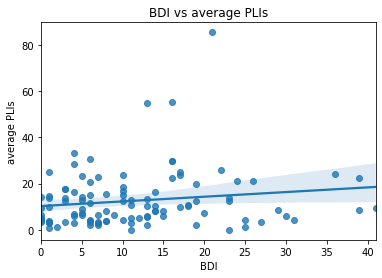

In [31]:
xi = 'BDI'
yi = 'average PLIs' #'Average correct recalls'/'average ints'

# x = df_filter[xi]
# y = df_filter[yi]

x = avg_df[xi]
y = avg_df[yi]

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
grad, inter, r, p, std_err = stats.linregress(x, y)

# plt.figure(figsize=(8, 8))
# plt.scatter(x, y)
# plt.plot(x, poly1d_fn(x), '--k')
# max_x = round(x.max(axis = 0) + 5, 5)
# max_y = round(y.max(axis = 0) + 5, 5)
# plt.xticks(np.arange(0, max_x, 5))
# plt.yticks(np.arange(0, max_y, 10))
# plt.xlabel(xi)
# plt.ylabel(yi)
print('r = ',r, 'p = ', p)
print('y =', grad, '*x + ', inter)
plt.figure(figsize=(8,6))
fig, ax = plt.subplots()
sb.regplot(data = df_filter, x=x, y=y, ax=ax)
plt.title(xi + ' vs ' + yi)
#plt.savefig(xi +' vs '+ yi + '.pdf')
# ax.set_xlim(0, 25)
# ax.set_xticks(range(0,25), 5)
#add error bars, combine FR/pyFR, catFR separate, check out Courier
#remove 5s and 4 intrusion criteria